Estimated Projection Matrix M:
 [[-7.97048929e+02  1.42917764e+00 -3.21273344e+02 -2.82081984e+00]
 [ 1.80607834e+00 -7.98104123e+02 -2.39884705e+02 -7.75501638e-01]
 [ 2.82830598e-03  2.99016963e-03 -9.99991530e-01 -1.82664251e-03]]

Estimated Intrinsic Matrix K:
 [[797.95293816  -1.60163435 319.020598  ]
 [  0.         798.81865932 237.50131472]
 [  0.           0.           1.        ]]

RMS reprojection error: 2.526 pixels


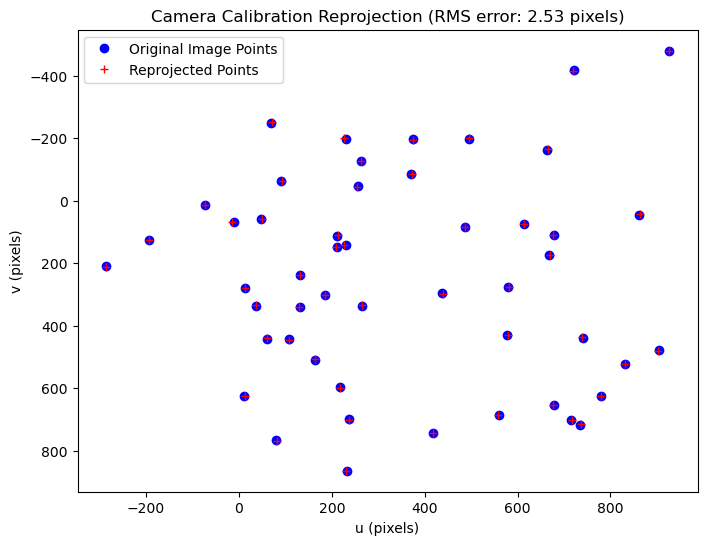

In [1]:
import numpy as np
import matplotlib.pyplot as plt


pts2d = np.loadtxt("pts2d.txt")
pts3d = np.loadtxt("pts3d.txt")


def calibrate_camera(pts3d, pts2d):
    """
    Estimate the 3x4 projection matrix M from corresponding 3D and 2D points.
    This follows the linear least-squares method described in Section 1.3.1.
    
    For each point, we form two equations:
      (P_i^T, 0^T, -x_i P_i^T) and (0^T, P_i^T, -y_i P_i^T)
    where P_i = [X, Y, Z, 1]^T and (x_i, y_i) are the image coordinates.
    Stacking these equations for all points leads to a homogeneous system P m = 0.
    We solve for m (the 12 entries of M) as the singular vector corresponding
    to the smallest singular value.
    """
    n = pts3d.shape[0]
    
    # Convert pts3d (n x 3) to homogeneous coordinates (n x 4)
    pts3d_h = np.hstack((pts3d, np.ones((n, 1))))
    
    # Build the 2n x 12 matrix for the homogeneous system.
    # For each correspondence (P_i, (x_i, y_i)):
    #   row1: [P_i^T, 0, 0, 0, 0, -x_i * P_i^T]
    #   row2: [0, 0, 0, 0, P_i^T, -y_i * P_i^T]
    P = []
    for i in range(n):
        X, Y, Z, W = pts3d_h[i]
        x, y = pts2d[i]
        row1 = np.hstack((pts3d_h[i], np.zeros(4), -x * pts3d_h[i]))
        row2 = np.hstack((np.zeros(4), pts3d_h[i], -y * pts3d_h[i]))
        P.append(row1)
        P.append(row2)
    P = np.array(P)
    
    # Solve P m = 0 using SVD.
    U, S, Vt = np.linalg.svd(P)
    m = Vt[-1, :]  # m is the singular vector corresponding to the smallest singular value
    M = m.reshape(3, 4)
    
    # Normalize M so that the norm of the third row (of the left 3x3 block) is 1.
    a3 = M[2, :3]
    M = M / np.linalg.norm(a3)
    
    return M

def decompose_M(M):
    """
    Decompose the estimated projection matrix M = [A | b] to recover the intrinsic
    calibration matrix K. Following the theory (Eqs. (1.24)–(1.26)):
      - Let a1, a2, a3 be the rows of A.
      - Compute ρ = 1/||a3||,
      - Then x0 = ρ² (a1 · a3) and y0 = ρ² (a2 · a3),
      - Compute cross products: cross1 = a1 × a3 and cross2 = a2 × a3.
      - Then cosθ = - (cross1 · cross2) / (||cross1|| ||cross2||) and θ = arccos(cosθ).
      - Finally, α = ρ² ||cross1|| sinθ and β = ρ² ||cross2|| sinθ.
    The calibration matrix is then given by:
      K = [ [α, -α cotθ, x0],
            [0,  β/sinθ, y0],
            [0,  0,      1] ]
    """
    A = M[:, :3]
    a1, a2, a3 = A[0, :], A[1, :], A[2, :]
    
    # Compute ρ as per Eq. (1.24)
    rho = 1.0 / np.linalg.norm(a3)
    
    # Compute the image center coordinates x0 and y0.
    x0 = (rho**2) * np.dot(a1, a3)
    y0 = (rho**2) * np.dot(a2, a3)
    
    # Compute cross products needed to estimate the rotation between a1, a2 and a3.
    cross1 = np.cross(a1, a3)
    cross2 = np.cross(a2, a3)
    norm_cross1 = np.linalg.norm(cross1)
    norm_cross2 = np.linalg.norm(cross2)
    
    # Compute the angle θ between the axes using Eq. (1.26)
    cos_theta = - np.dot(cross1, cross2) / (norm_cross1 * norm_cross2)
    # Clip to avoid numerical errors
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    theta = np.arccos(cos_theta)
    sin_theta = np.sin(theta)
    
    # Compute the magnifications α and β.
    alpha = (rho**2) * norm_cross1 * sin_theta
    beta  = (rho**2) * norm_cross2 * sin_theta
    
    # Compute cotθ (cotangent of theta)
    cot_theta = cos_theta / sin_theta if sin_theta != 0 else 0
    
    # Form the intrinsic matrix K (see Eq. (1.11))
    K = np.array([[alpha, -alpha * cot_theta, x0],
                  [0,     beta / sin_theta,   y0],
                  [0,     0,                  1]])
    
    return K

def project_points(M, pts3d):
    """
    Project the 3D points using the projection matrix M.
    Each 3D point is first converted to homogeneous coordinates.
    The projected point p = M * P is then normalized (dividing by the third coordinate)
    to yield the inhomogeneous image coordinates.
    """
    n = pts3d.shape[0]
    pts3d_h = np.hstack((pts3d, np.ones((n, 1))))
    proj = (M @ pts3d_h.T).T  # shape (n, 3)
    proj = proj / proj[:, [2]]  # normalize by the third (scale) coordinate
    return proj[:, :2]

def compute_rms_error(pts2d, pts2d_proj):
    """
    Compute the root-mean-squared (RMS) error between the observed image points and
    the projected image points.
    """
    error = pts2d - pts2d_proj
    rms = np.sqrt(np.mean(np.sum(error**2, axis=1)))
    return rms

def main():
    # In a real assignment, pts2d and pts3d are provided.
    # For demonstration, we generate synthetic data.
    np.random.seed(0)
    n = 50  # number of points
    
    # Generate random 3D points.
    # We ensure that the z-values are negative (points in front of the camera).
    # pts3d = np.random.uniform(-1, 1, (n, 3))
    pts3d[:, 2] = -np.abs(pts3d[:, 2]) - 1  # shift to negative depths
    
    # Define a "true" projection matrix (simulate a camera).
    # Here we set intrinsic parameters (e.g., focal lengths and principal point).
    alpha_true = 800
    beta_true = 800
    theta_true = np.pi / 2  # zero skew (cot(theta) = 0)
    x0_true = 320
    y0_true = 240
    K_true = np.array([[alpha_true, 0,         x0_true],
                       [0,          beta_true,  y0_true],
                       [0,          0,         1]])
    # For simplicity, use an identity rotation and zero translation.
    R_true = np.eye(3)
    t_true = np.zeros((3, 1))
    M_true = K_true @ np.hstack((R_true, t_true))  # 3x4 projection matrix
    
    # Project the 3D points using the true projection matrix.
    pts2d_proj_true = project_points(M_true, pts3d)
    # Add a small amount of noise to simulate measurement error.
    pts2d = pts2d_proj_true + np.random.normal(0, 2, pts2d_proj_true.shape)
    
    # ---- Camera Calibration Steps ----
    
    # 1. Estimate the projection matrix M using the linear method (Eq. 1.21).
    M_est = calibrate_camera(pts3d, pts2d)
    print("Estimated Projection Matrix M:\n", M_est)
    
    # 2. Decompose M to recover the intrinsic calibration matrix K.
    K_est = decompose_M(M_est)
    print("\nEstimated Intrinsic Matrix K:\n", K_est)
    
    # 3. Reproject the 3D points using the estimated M.
    pts2d_reproj = project_points(M_est, pts3d)
    
    # 4. Compute the RMS reprojection error.
    rms_error = compute_rms_error(pts2d, pts2d_reproj)
    print("\nRMS reprojection error: {:.3f} pixels".format(rms_error))
    
    # 5. Plot the original image points and the reprojected points.
    plt.figure(figsize=(8, 6))
    plt.plot(pts2d[:, 0], pts2d[:, 1], 'bo', label='Original Image Points')
    plt.plot(pts2d_reproj[:, 0], pts2d_reproj[:, 1], 'r+', label='Reprojected Points')
    plt.title(f'Camera Calibration Reprojection (RMS error: {rms_error:.2f} pixels)')
    plt.xlabel('u (pixels)')
    plt.ylabel('v (pixels)')
    plt.legend()
    # If image coordinates are defined with the origin at the bottom left, you may invert the y-axis:
    plt.gca().invert_yaxis()
    plt.show()

if __name__ == '__main__':
    main()


Projection matrix M:
[[-4.53359881e-03 -5.65451256e-04  2.02849590e-03 -5.23179344e-01]
 [-1.84278426e-03  4.15975903e-03 -1.68779276e-03 -8.52192928e-01]
 [-3.25683227e-06 -1.13804182e-06 -3.35237791e-06 -1.43209220e-03]]

Intrinsic matrix K:
[[9.70284101e+02 9.86348408e-02 3.72004964e+02]
 [0.00000000e+00 9.63346581e+02 2.99292094e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Rotation matrix R:
[[-0.71171772 -0.03054192  0.70180131]
 [-0.18731413  0.97113272 -0.14769783]
 [-0.67703124 -0.23657647 -0.6968933 ]]

Translation vector t:
[   2.05879063  -91.40400685 -297.70374575]

Root-mean-squared reprojection error: 0.9574 pixels


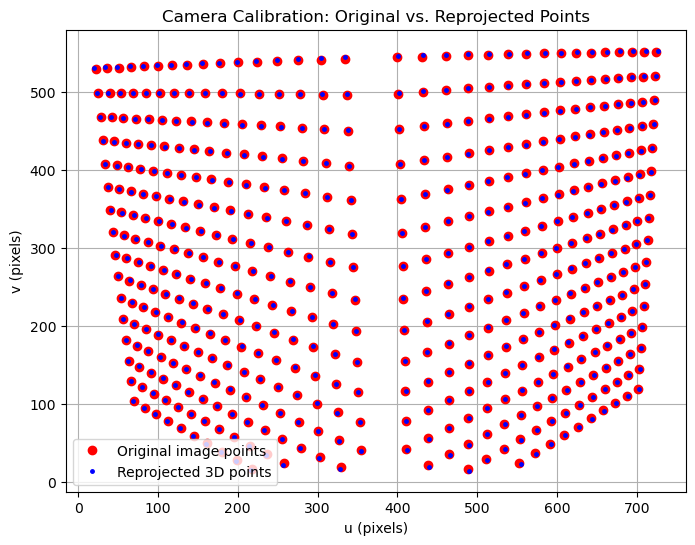

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def compute_projection_matrix(pts2d, pts3d):
    n = pts2d.shape[0]
    A = []
    for i in range(n):
        X, Y, Z = pts3d[i]
        u, v = pts2d[i]
        row1 = [X, Y, Z, 1, 0, 0, 0, 0, -u*X, -u*Y, -u*Z, -u]
        row2 = [0, 0, 0, 0, X, Y, Z, 1, -v*X, -v*Y, -v*Z, -v]
        A.append(row1)
        A.append(row2)
    A = np.array(A)
    
    U, S, Vt = np.linalg.svd(A)
    m = Vt[-1]
    M = m.reshape(3, 4)
    return M

def decompose_projection_matrix(M):
    A_mat = M[:, :3]
    b = M[:, 3]
    
    a1 = A_mat[0, :]
    a2 = A_mat[1, :]
    a3 = A_mat[2, :]
    
    norm_a3 = np.linalg.norm(a3)
    rho = 1.0 / norm_a3
    r3 = rho * a3
    
    x0 = (rho**2) * np.dot(a1, a3)
    y0 = (rho**2) * np.dot(a2, a3)
    
    a1_cross_a3 = np.cross(a1, a3)
    a2_cross_a3 = np.cross(a2, a3)
    norm_a1_cross_a3 = np.linalg.norm(a1_cross_a3)
    norm_a2_cross_a3 = np.linalg.norm(a2_cross_a3)
    
    cos_theta = -np.dot(a1_cross_a3, a2_cross_a3) / (norm_a1_cross_a3 * norm_a2_cross_a3)
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    theta = np.arccos(cos_theta)
    sin_theta = np.sin(theta)
    
    alpha = (rho**2) * norm_a1_cross_a3 * sin_theta
    beta  = (rho**2) * norm_a2_cross_a3 * sin_theta
    
    K = np.array([
        [alpha, -alpha * (cos_theta / sin_theta), x0],
        [0,     beta / sin_theta,               y0],
        [0,     0,                              1]
    ])
    
    r1 = a2_cross_a3 / norm_a2_cross_a3
    r2 = np.cross(r3, r1)
    R = np.vstack([r1, r2, r3])
    
    t = rho * np.linalg.inv(K) @ b
    
    return K, R, t

def compute_reprojection_error(M, pts3d, pts2d):
    n = pts3d.shape[0]
    pts3d_h = np.hstack([pts3d, np.ones((n, 1))])
    projected_h = (M @ pts3d_h.T).T
    projected = projected_h[:, :2] / projected_h[:, 2, np.newaxis]
    error = np.sqrt(np.mean(np.sum((projected - pts2d)**2, axis=1)))
    return projected, error

def plot_reprojection(pts2d, projected):
    plt.figure(figsize=(8, 6))
    # Plot original 2D points as red circles.
    plt.plot(pts2d[:, 0], pts2d[:, 1], 'ro', label='Original image points')
    # Plot reprojected 3D points as blue dots.
    plt.plot(projected[:, 0], projected[:, 1], 'b.', markersize=5, label='Reprojected 3D points')
    plt.xlabel('u (pixels)')
    plt.ylabel('v (pixels)')
    plt.title('Camera Calibration: Original vs. Reprojected Points')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    pts2d = np.loadtxt("pts2d.txt")
    pts3d = np.loadtxt("pts3d.txt")
    
    M = compute_projection_matrix(pts2d, pts3d)
    print("Projection matrix M:")
    print(M)
    
    K, R, t = decompose_projection_matrix(M)
    print("\nIntrinsic matrix K:")
    print(K)
    print("\nRotation matrix R:")
    print(R)
    print("\nTranslation vector t:")
    print(t)
    
    projected, rms_error = compute_reprojection_error(M, pts3d, pts2d)
    print("\nRoot-mean-squared reprojection error: {:.4f} pixels".format(rms_error))
    
    plot_reprojection(pts2d, projected)

if __name__ == '__main__':
    main()
